In [1]:
#%reset -f -s

In [2]:
'''------------------------------------------------------------------
---------------------------------------------------------------------
LSTM Training
---------------------------------------------------------------------
Version: V1.7       Modified: 06.11.2024        William Siegle
---------------------------------------------------------------------
notebook can be converted to python script using: 
(python -m) jupytext --to py FILENAME.ipynb
------------------------------------------------------------------'''
#import pathlib
from pathlib import Path, WindowsPath, PosixPath


# SETTINGS ------------------------------------------------------------------------
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "GPU_SELECT":       0, # {0,1,2,3, None: CPU only}
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_pinn_2"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "SEED"  :           1,
    "PLOT_ACTIVE":      True,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.15, 0.05], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "SCALERS":          {'feature_scaler': 'MaxAbsScaler()',
                        'target_scaler': 'MinMaxScaler(feature_range=(0, 1))',
                        'prior_scaler': 'MinMaxScaler(feature_range=(0, 1))'},
    "MIN_SEQ_LENGTH":   3600, # minimum sequence length in s to be included in DataSets

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ['actdrvtrnpwrprc_cval','altitude_cval_ippc','motortemperature_pti1',
                        'brktempra_cval','hv_batmaxdischrgpwrlim_cval_1',
                        'actualtorque_pti1','powerstagetemperature_pti1',
                        'accelpdlposn_cval','airtempoutsd_cval_cpc','airtempinsd_cval_hvac','actualdcvoltage_pti1','hv_batavcelltemp_cval_bms1',
                        'epto_pwr_cval','maxtracpwrpct_cval','airtempinsd_rq','bs_brk_cval','brc_stat_brc1','vehspd_cval_cpc',
                        'vehweight_cval_pt','actualspeed_pti1','selgr_rq_pt',
                        'rmsmotorcurrent_pti1','roadgrad_cval_pt','currpwr_contendrnbrkresist_cval','elcomp_pwrcons_cval',
                        'hv_ptc_cabin1_pwr_cval','maxrecuppwrprc_cval','txoiltemp_cval_tcm', 'start_soc',
                        'hv_curr_cval_dcl1','hv_dclink_volt_cval_dcl1','hv_pwr_cval_dcl1','lv_convpwr_cval_dcl1','hv_batmaxchrgpwrlim_cval_1'],
                        
    "TARGETS":          ['hv_bat_soc_cval_bms1'],
    "PRIORS":           ['emot_soc_pred'],  

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      256,    # features in the hidden state h
    "NUM_LAYERS":       6,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.2,
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       10,
    "BATCH_SIZE":       32,   # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
    "LEARNING_RATE":    1e-4,   # 0.001 lr
    "OPTIMIZER":        "torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-3)",      
                        # weight_decay = 1e-4     # weight decay coefficient (default: 1e-2)
                        # betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
                        # eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
    "LRSCHEDULER":      "torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 3, factor = 0.5, min_lr = 1e-7)",

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", # ['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']
    "LOSS_FN":          "F.mse_loss(output, target)", # ['F.mse_loss(output, target)', 'F.l1_loss(output, target)', 'F.smooth_l1_loss(output, target)', 'F.huber_loss(output, target)', 'F.mase_loss(output, target)']

    # SAVE & LOAD: -----------------------------------------------------------------
    "MODE":             "train_mode", # ['train_mode', 'test_mode']
    "TRAIN_LOG":        "test2.txt",

}
for key in CONFIG: globals()[key] = CONFIG[key];
print(ROOT)

/home/sieglew/MA-eR-PINN


___
LOCATE DEVICES & SYSTEM FOLDERS

In [3]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
# ----------------------------------------------------------------------------------------
import sys, os
for key in CONFIG: globals()[key] = CONFIG[key]
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
sys.path.append(os.path.abspath(ROOT))

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
from src.__init__ import *
from src.utils.data_utils import *
from src.utils.preprocess_utils import *
from src.utils.eval_utils import *
from src.utils.Trainers import *
#from src.LSTM.lstm_models import *

# SETUP ENVIRONMENT ---------------------------------------------------------------------
DATA_PATH, IS_NOTEBOOK, DEVICE = setup_environment(CONFIG, ROOT, SEED, GPU_SELECT)

------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			project, ref, test, data, src, .git, archive
  /home/sieglew/MA-Data:			__pycache__, trips_processed_resampled, final, y_true, processed, TripSequences, trips_processed_pickles, final_2, trips_processed_final
------------------------------------------------------------
Running in notebook mode
CONFIG Dictionary:
---------------------------------------------------------------------------------------------------------------------------------
     Parameter        Value
--  ---------------  ------------------------------------------------------------------------------------------------------------
0   GPU_SELECT       0
1   ROOT             /home/sieglew/MA-eR-PINN
2   INPUT_LOCATION   TripSequences/trips_processed_pinn_2
3   OUTPUT_LOCATION  src/models/pth
4   SEED             1
5   PLOT_ACTIVE      True
6   TRAIN_VAL_TEST   [0.8, 0.15, 0.05]
7   MAX_FILES        None
8   SCALERS      

In [4]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION)
files, trip_lengths, indices_by_length, sorted_trip_lengths, all_signals = prepare_data(input_folder, pth_folder, MAX_FILES, MIN_SEQ_LENGTH, ROOT)

------------------------------------------------------------
Total Files:	16116
------------------------------------------------------------
Obtaining sequence lengths... (may take up to 5 minutes)
Filtered Files:	3721
------------------------------------------------------------
               FileName  Length  Index
0       V13_T25.parquet   20843    471
1      V18_T775.parquet   19425   1393
2      V13_T352.parquet   18308    456
3      V18_T972.parquet   17858   1871
4     V16_T1629.parquet   17519    916
...                 ...     ...    ...
3716   V18_T953.parquet    3612   2804
3717   V12_T252.parquet    3609    949
3718   V13_T381.parquet    3609   3325
3719    V4_T280.parquet    3606   1355
3720  V16_T1545.parquet    3606   2252

[3721 rows x 3 columns]


___
DATA PREPROCESSING

In [5]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
                "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped (from Features) in order for appropriate training:
columns_to_drop = ["signal_time",                       # works as index
                    "hirestotalvehdist_cval_icuc",      # starts from 0, obtained by speed integration
                    "latitude_cval_ippc",               # only GPS 
                    "longitude_cval_ippc",              # only GPS
                    "hv_batpwr_cval_bms1",              # directly related to target (soc_gradient)
                    "hv_batmomavldischrgen_cval_1",     # indirect target 1 in kWh
                    "hv_bat_soc_cval_bms1",              # indirect target 2 in %SoC
                    "soc_gradient",                     # actual target signal   
                    "emot_pwr_cval",                    # replaced as physical prior for PINN
                    "emot_pwr_pred",                    # actual physical prior for PINN
                    ]

# Ensure no element of "columns_to_drop" is included in "FEATURES"
assert not any(col in FEATURES for col in columns_to_drop), "Some columns to drop are still in FEATURES"

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

In [6]:
# FEATURE SELECTION  ----------------------------------------------------------------------------
INPUT_COLUMNS = FEATURES; TARGET_COLUMN = TARGETS; PRIOR_COLUMN = PRIORS
print(f"{'-'*60}\nInput Signals:\t{len(FEATURES)}\nTarget Signals:\t{len(TARGETS)}\nPhysical Prior Signals:\t{len(PRIORS)}\n{'-'*60}")

# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])
prior_scaler = eval(SCALERS['prior_scaler'])

------------------------------------------------------------
Input Signals:	34
Target Signals:	1
Physical Prior Signals:	1
------------------------------------------------------------


In [7]:
# GENERATE DATALOADERS ---------------------------------------------------------------

# DATA SET SPLITTING AND SORTING ----------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

# DATALOADER SETTINGS ------------------------------------------------------------------
dataloader_settings = {
    'batch_size': 1,                    # see *Note above
    'shuffle': True,                    # shuffle the batches before each epoch
    'collate_fn': collate_fn_PINN,      # include optional arguments
    'num_workers': 8,                   # number of workers
    'prefetch_factor': 4,               # number of samples loaded in advance by each worker
    'persistent_workers': True,         # whether the data loader workers are allowed to persist
    'pin_memory': False if DEVICE.type == 'cpu' else True}

# PREPARE TRAIN, VAL & TEST DATALOADERS  ------------------------------------------------------------
train_subset, train_dataset, train_dataset_batches, train_loader = prepare_dataloader_PINN(train_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, fit=True, drop_last=True)

val_subset, val_dataset, val_dataset_batches, val_loader = prepare_dataloader_PINN(val_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=True)

test_subset, test_dataset, test_dataset_batches, test_loader = prepare_dataloader_PINN(test_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=True)

# print dataset info
subset_files = print_dataset_sizes(train_dataset, val_dataset, test_dataset, train_subset, val_subset, test_subset, files)

 --> Warning: Removed the last 1 samples to ensure a balanced batch size
fitting Scalers: MaxAbsScaler, MinMaxScaler, MinMaxScaler
	50% of the fitting done...
Done. Create DataSets and DataLoaders...


KeyboardInterrupt: 

In [83]:
if IS_NOTEBOOK and False: 
    check_batch_PINN(train_loader)
    #visualize_padding(BATCH_SIZE, trip_lengths, sorted_trip_lengths, train_loader, val_loader, test_loader)

In [84]:
# LSTM NETWORK -----------------------------------------------------------------------

class LSTM1_packed_old_version(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device=DEVICE):
        super(LSTM1_packed_old_version, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            self.input_size,            # The number of expected features in the input x
            self.hidden_size,           # The number of features in the hidden state h
            self.num_layers,            # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first=True,           # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            bias=True,                  # If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            dropout=self.dropout,       # usually: [0.2 - 0.5], introduces a Dropout layer on the outputs of each LSTM layer except the last layer, (dropout probability). Default: 0
            bidirectional=False,        # If True, becomes a bidirectional LSTM. Default: False
            proj_size=0,                # If > 0, will use LSTM with projections of corresponding size. Default: 0
            device=device)

        # LAYERS -----------------------------------
        self.dropout_layer = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.bn2 = nn.BatchNorm1d(hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, 1)
        self.relu = nn.ReLU()
    
    def forward(self, packed_input, batch_size=None):
        packed_out, _ = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.relu(out)  # relu
        out = self.dropout_layer(out)  # dropout
        out = self.fc1(out)  # fully connected layer 1
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)  # relu
        out = self.fc2(out)  # fully connected layer 2
        out = self.bn2(out.transpose(1, 2)).transpose(1, 2)  # batch normalization 2
        out = self.relu(out)  # relu
        out = self.fc3(out)  # fully connected layer 3
        return out


In [85]:
# MODEL CONFIGURATION -----------------------------------------------------------------------

# INSTANTIATE MODEL --------------------
model = LSTM1_packed_old_version(len(INPUT_COLUMNS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
print(f"{'-'*60}\n", model, f"{'-'*60}\nModel state_dict:")
for param_tensor in model.state_dict(): print(f"{param_tensor}:\t {model.state_dict()[param_tensor].size()}") 
# --> Note torch.Size([4*hidden_size, input_size]) for LSTM weights because of i,o,f,g params concatenated

------------------------------------------------------------
 LSTM1_packed_old_version(
  (lstm): LSTM(34, 256, num_layers=6, batch_first=True, dropout=0.2)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
) ------------------------------------------------------------
Model state_dict:
lstm.weight_ih_l0:	 torch.Size([1024, 34])
lstm.weight_hh_l0:	 torch.Size([1024, 256])
lstm.bias_ih_l0:	 torch.Size([1024])
lstm.bias_hh_l0:	 torch.Size([1024])
lstm.weight_ih_l1:	 torch.Size([1024, 256])
lstm.weight_hh_l1:	 torch.Size([1024, 256])
lstm.bias_ih_l1:	 torch.Size([1024])
lstm.bias_hh_l1:	 torch.Size([1024])
lstm.weight_

In [86]:
# TRAINING CONFIGURATION -----------------------------------------------------------------------
# OPTIMIZER, LR SCHEDULER, CRITERION----------------------------------------------------------------------------
optimizer = eval(OPTIMIZER) # common optimizers: ['torch.optim.Adam', 'torch.optim.SGD', 'torch.optim.RMSprop']
scheduler = eval(LRSCHEDULER)
criterion = eval(CRITERION) # criterion_list = [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss(), nn.HuberLoss(), MASE()]
print(f"{'-'*60}\n{optimizer}\n{'-'*60}\nLRScheduler: {scheduler.__class__}\n{'-'*60}\n{'-'*60}\nCriterion: {criterion.__class__}\n{'-'*60}\n")

------------------------------------------------------------
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.001
)
------------------------------------------------------------
LRScheduler: <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>
------------------------------------------------------------
------------------------------------------------------------
Criterion: <class 'torch.nn.modules.loss.SmoothL1Loss'>
------------------------------------------------------------



In [87]:
# LOSS FUNCTION ----------------------------------------------------------------   
def loss_fn_PINN_1(output, target, prior):
    loss = F.mse_loss(output, target, reduction='mean') # mean-squared error for regression
    return loss
    
# ---------------------------------------------------------------------------------
def loss_fn_PINN_2(output, target, prior):
    l_p = 0.7
    y_pred = output
    y_true = target
    y_phys = prior

    mse_loss = F.mse_loss(y_pred, y_true, reduction='mean')
    phys_loss = F.mse_loss(y_pred, y_phys, reduction='mean')

    total_loss = (1-l_p)*mse_loss + l_p*phys_loss
    return total_loss

# ---------------------------------------------------------------------------------
def loss_fn_PINN_3(output, target, prior):
    l_p = 0.7

    y_pred = output
    y_true = target
    y_phys = prior

    total_loss = F.mse_loss(y_true, (l_p * y_phys + (1 - l_p) * y_pred), reduction='mean')
    
    return total_loss

In [88]:
# SET NETWORK TRAINER -----------------------------------------------------------------
TRAINER = PTrainer_PINN(
    model = model, 
    optimizer = optimizer,
    scheduler = scheduler, 
    loss_fn = loss_fn_PINN_2, 
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    num_epochs = NUM_EPOCHS, 
    device = DEVICE, 
    is_notebook = IS_NOTEBOOK,
    use_mixed_precision = False,
    log_file = TRAIN_LOG)

In [89]:
# START TRAINING -----------------------------------------------------------------
if MODE == 'train_mode': CHECKPOINT = TRAINER.train_model()

------------------------------------------------------------
Training Started.	Process ID: 1536018 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	93 / 1
Loss:			<function loss_fn_PINN_2 at 0x7eff5c994c20>
Optimizer:		AdamW
LR:			0.0001
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

  0%|          | 0/93 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:17:57
------------------------------------------------------------



In [90]:
CHECKPOINT, model_destination_path = save_checkpoint(TRAINER, train_loader, val_loader, test_loader, CHECKPOINT, CONFIG, subset_files, pth_folder)

Model saved to:	 /home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_packed_old_version_241216_103745.pth
------------------------------------------------------------
Size: 34.28 MB
------------------------------------------------------------


In [91]:
#%%skip
# LOAD MODEL -----------------------------------------------------------------
#model_destination_path = Path(pth_folder, "LSTM1_packed_old_version_241216_082030.pth")
CHECKPOINT = load_checkpoint(model_destination_path, DEVICE)

# get model type:
for key in CHECKPOINT.keys(): globals()[key] = CHECKPOINT[key]

# load model and optimizer states
model.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)
model.eval()  # set model to evaluation mode for inference

print(f"Model loaded from:\t{model_destination_path}\n{'-'*60}\nModel: {model.__class__.__name__}\tParameters on device: {next(model.parameters()).device}"
        f"\n{'-'*60}\nTrain/Batch size:\t{len(train_loader.dataset)} / {train_loader.batch_size}\n"
        f"Loss:\t\t\t{loss_fn}\nOptimizer:\t\t{optimizer.__class__.__name__}\nLR:\t\t\t"
        f"{optimizer.param_groups[0]['lr']}\nWeight Decay:\t\t{optimizer.param_groups[0]['weight_decay']}\n{'-'*60}\n", model)

Model loaded from:	/home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_packed_old_version_241216_103745.pth
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: cuda:0
------------------------------------------------------------
Train/Batch size:	93 / 1
Loss:			<function loss_fn_PINN_2 at 0x7eff5c994c20>
Optimizer:		AdamW
LR:			0.0001
Weight Decay:		0.001
------------------------------------------------------------
 LSTM1_packed_old_version(
  (lstm): LSTM(34, 256, num_layers=6, batch_first=True, dropout=0.2)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


___

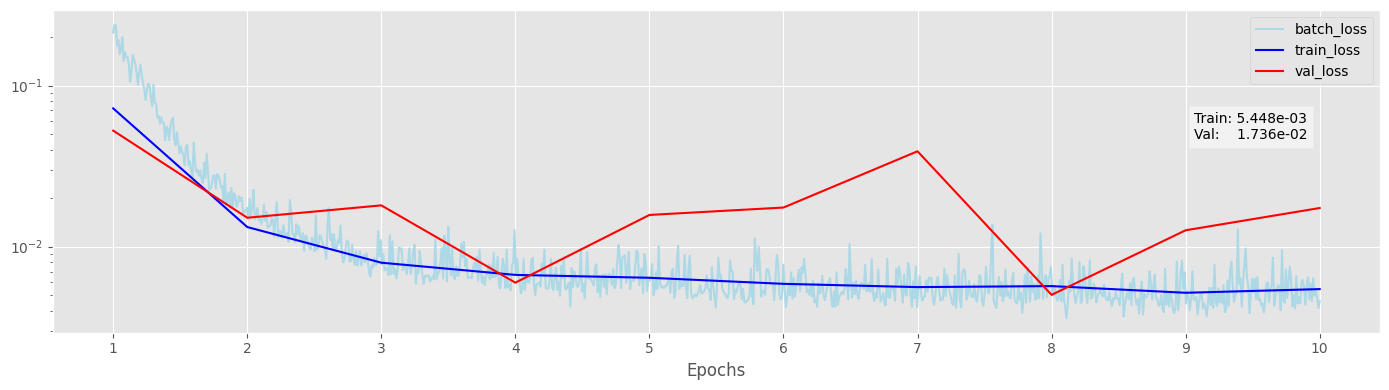

In [92]:
# PLOT TRAINING PERFORMANCE -----------------------------------------------------------------
# get DataFrame of training metrics:
keys = ['training_table', 'train_losses_per_iter', 'train_losses', 'val_losses', 'lr_history', 'train_batches']
training_table, train_losses_per_iter, train_losses, val_losses, lr_history, train_batches = (CHECKPOINT[key] for key in keys)
training_df = pd.DataFrame(training_table, columns=["Epoch", "Iteration", "Batch Loss", "Train Loss"])

# -------------------------------------
#NUM_EPOCHS = CONFIG['NUM_EPOCHS']
plot_training_performance(training_df, train_losses_per_iter, train_losses, val_losses, lr_history, train_batches, NUM_EPOCHS)

In [95]:
# EVALUATION -----------------------------------------------------------------
# get file list of test subset
test_files = CHECKPOINT["test_files"]; print(f"{'-'*60}\nTest subset: {len(test_files)} files\n{'-'*60}")
# -------------------------------------
# evaluate model on test set
test_loss, all_outputs, all_targets, all_priors, all_original_lengths = TRAINER.evaluate_model()
# -------------------------------------
# Inverse-transform on all outputs and targets for evaluation
scaled_outputs = [target_scaler.inverse_transform(output_sequence.reshape(1, -1)).squeeze() for output_sequence in all_outputs]
scaled_targets = [target_scaler.inverse_transform(target_sequence.reshape(1, -1)).squeeze() for target_sequence in all_targets]
scaled_priors = [prior_scaler.inverse_transform(prior_sequence.reshape(1, -1)).squeeze() for prior_sequence in all_priors]

# concatenate:
all_y_true, all_y_pred, all_y_phys = np.concatenate(scaled_targets), np.concatenate(scaled_outputs), np.concatenate(scaled_priors)

# calculate evaluation metrics
metrics = {
    "rmse": root_mean_squared_error(all_y_true, all_y_pred),                  # Root Mean Squared Error
    "mae": np.mean(np.abs(all_y_true - all_y_pred)),                          # Mean Absolute Error
    "std_dev": np.std(all_y_true - all_y_pred),                               # Standard Deviation
    "mape": np.mean(np.abs((all_y_true - all_y_pred) / all_y_true)) * 100,    # Mean Absolute Percentage Error
    "r2": r2_score(all_y_true, all_y_pred)}                                   # R-squared

print(f"Test Loss:\t\t{test_loss:.6f}\nRMSE:\t\t\t{metrics['rmse']:.4f}\
    \nMAE ± STD (MAPE):\t{metrics['mae']:.4f} ± {metrics['std_dev']:.4f} ({metrics['mape']:.2f}%)\nR-squared:\t\t{metrics['r2']:.4f}")

------------------------------------------------------------
Test subset: 160 files
------------------------------------------------------------
Test Loss:		0.017453
RMSE:			16.3929    
MAE ± STD (MAPE):	15.7451 ± 4.5777 (32.52%)
R-squared:		0.4366


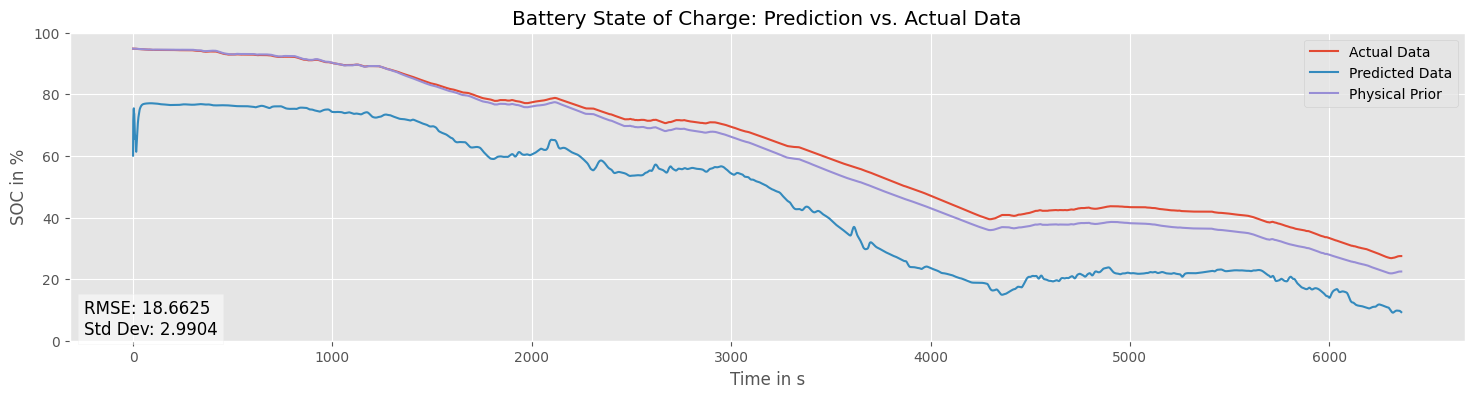

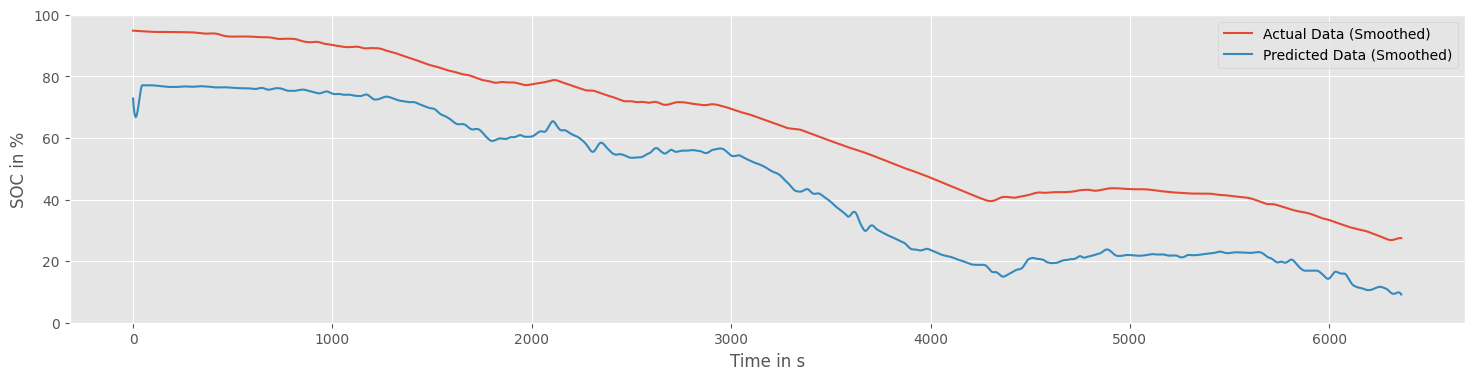

In [139]:
# PLOT RESULTS -----------------------------------------------------------------
# get random sample sequence from test set
# -------------------------------------
sample_int = random.randint(1, len(scaled_outputs)-1)
y_true, y_pred, y_phys = scaled_targets[sample_int], scaled_outputs[sample_int], scaled_priors[sample_int]

###############################################
# PLOT PREDICTION -----------------------------------------------------------------
if PLOT_ACTIVE:
     plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %'); plt.title('Battery State of Charge: Prediction vs. Actual Data') 
     plt.plot(y_true, label='Actual Data') # actual plot
     plt.plot(np.arange(0, len(y_true), 1), y_pred, label='Predicted Data') # predicted plot
     plt.plot(y_phys, label='Physical Prior') # physical prior
     plt.ylim(0, 100) # set y-axis limits

     plt.legend()
     plt.text(0.01, 0.02, f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}\nStd Dev: {np.std(y_true - y_pred):.4f}",\
          transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

     plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %')
     plt.plot(savgol_filter(y_true.flatten(), window_length=60, polyorder=3), label='Actual Data (Smoothed)') # actual plot
     plt.plot(np.arange(0, len(y_true), 1), savgol_filter(y_pred.flatten(), window_length=60, polyorder=3), label='Predicted Data (Smoothed)') # predicted plot
     plt.ylim(0, 100) # set y-axis limits
     plt.legend();